# Линейная алгебра: сходство текстов и аппроксимация функций

Данное задание основано на материалах секции, посвященной введению в линейную алгебру. Вам понадобится компьютер с установленным интерпретатором Python и подключенными библиотеками NumPy и SciPy.

### Вы научитесь:
  * читать тексты из файла с помощью Python и разбивать их на слова
  * переводить тексты в векторные пространства, вычислять расстояния в этих пространствах
  * решать системы линейных уравнений
  * приближать любые функции с помощью многочленов
  
## Введение

В этом задании вы познакомитесь с некоторыми базовыми методами из линейной алгебры, реализованными в пакете SciPy — в частности, с методами подсчета косинусного расстояния и решения систем линейных уравнений. Обе эти задачи еще много раз встретятся нам в специализации. Так, на решении систем линейных уравнений основана настройка линейных моделей — очень большого и важного класса алгоритмов машинного обучения. Косинусное расстояние же часто используется в анализе текстов для измерения сходства между ними.

## Материалы

Справка по функциям пакета scipy.linalg: http://docs.scipy.org/doc/scipy/reference/linalg.html

Справка по работе с файлами в Python: https://docs.python.org/2/tutorial/inputoutput.html#reading-and-writing-files

Справка по регулярным выражениям в Python (если вы захотите узнать про них чуть больше): https://docs.python.org/2/library/re.html

## Задача 1: сравнение предложений

Дан набор предложений, скопированных с Википедии. Каждое из них имеет "кошачью тему" в одном из трех смыслов:

  * кошки (животные)
  * UNIX-утилита cat для вывода содержимого файлов
  * версии операционной системы OS X, названные в честь семейства кошачьих
Ваша задача — найти два предложения, которые ближе всего по смыслу к расположенному в самой первой строке. В качестве меры близости по смыслу мы будем использовать косинусное расстояние.

#### Выполните следующие шаги:

1. Скачайте файл с предложениями (sentences.txt).
2. Каждая строка в файле соответствует одному предложению. Считайте их, приведите каждую к нижнему регистру с помощью строковой функции lower().
3. Произведите токенизацию, то есть разбиение текстов на слова. Для этого можно воспользоваться регулярным выражением, которое считает разделителем любой символ, не являющийся буквой: <code>re.split('[^a-z]', t)</code>. Не забудьте удалить пустые слова после разделения.
4. Составьте список всех слов, встречающихся в предложениях. Сопоставьте каждому слову индекс от нуля до (d - 1), где d — число различных слов в предложениях. Для этого удобно воспользоваться структурой dict.
5. Создайте матрицу размера n x d, где n — число предложений. Заполните ее: элемент с индексом (i, j) в этой матрице должен быть равен количеству вхождений j-го слова в i-е предложение. У вас должна получиться матрица размера 22 * 254.
6. Найдите косинусное расстояние от предложения в самой первой строке (In comparison to dogs, cats have not undergone...) до всех остальных с помощью функции scipy.spatial.distance.cosine. Какие номера у двух предложений, ближайших к нему по этому расстоянию (строки нумеруются с нуля)? Эти два числа и будут ответами на задание.
7. Запишите полученные числа в файл, разделив пробелом. Обратите внимание, что файл должен состоять из одной строки, в конце которой не должно быть переноса. Пример файла с решением вы можете найти в конце задания (submission-1.txt).
8. Совпадают ли ближайшие два предложения по тематике с первым? Совпадают ли тематики у следующих по близости предложений?

Разумеется, использованный вами метод крайне простой. Например, он не учитывает формы слов (так, cat и cats он считает разными словами, хотя по сути они означают одно и то же), не удаляет из текстов артикли и прочие ненужные слова. Позже мы будем подробно изучать анализ текстов, где выясним, как достичь высокого качества в задаче поиска похожих предложений.

In [1]:
import numpy as np
from scipy.spatial.distance import cosine
import re
import pandas as pd

In [2]:
file_string = ''
sentencies = []

with open('sentences.txt', 'r') as file:

    for line in file:
        file_string += line
        sentencies.append(line.strip().lower())
    
file_string = file_string.lower()
words = list(re.split('[^a-z]', file_string))
words = [elem for elem in words if elem != '']
words_dict = dict()
index = 0
for word in words:
    if word not in words_dict.values():
        words_dict[index] = word
        index += 1

n = len(sentencies)
d = len(words_dict.keys())
matrix = np.zeros(shape=(n, d))


for i in range(n):
    for j in range(d):
        if list(words_dict.values())[j] in re.split('[^a-z]', sentencies[i]):
            matrix[i, j] += 1

min_distance = 1000           
result = dict()       
for i in range(1,n):
    distance = cosine(matrix[i], matrix[0])
    result[i] =  distance

distances_df = pd.DataFrame.from_dict(result, orient = 'index')
distances_df.columns = ['distance']
distances_df['sentence'] = list(map(lambda x: sentencies[x], distances_df.index.values))
distances_df.sort_values('distance')[:5]

,distance,sentence
6,0.754744,domestic cats are similar in size to the other...
4,0.805539,"in one, people deliberately tamed cats in a pr..."
21,0.825036,"the fifth major update to mac os x, leopard, c..."
20,0.842757,"mac os x mountain lion installs in place, so y..."
16,0.853615,since apple moved to using intel processors in...


## Задача 2: аппроксимация функции

Рассмотрим сложную математическую функцию на отрезке [1, 15]:

$$f(x) = sin(\frac{x}{5}) * exp(\frac{x}{10}) + 5 * exp(\frac{-x}{2})$$

Она может описывать, например, зависимость оценок, которые выставляют определенному сорту вина эксперты, в зависимости от возраста этого вина. По сути, задача машинного обучения состоит в том, чтобы приблизить сложную зависимость с помощью функции из определенного семейства. В этом задании мы будем приближать указанную функцию с помощью многочленов.

Как известно, многочлен степени n (то есть $w_0 + w_1 x + w_2 x^2 + ... + w_n x^n$) однозначно определяется любыми n + 1 различными точками, через которые он проходит. Это значит, что его коэффициенты $w_0, ... w_n$ можно определить из следующей системы линейных уравнений:


где через $x_1, ..., x_n, x_{n+1}$ обозначены точки, через которые проходит многочлен, а через $f(x_1), ..., f(x_n), f(x_{n+1})$ — значения, которые он должен принимать в этих точках.

Воспользуемся описанным свойством, и будем находить приближение функции многочленом, решая систему линейных уравнений.

1. Сформируйте систему линейных уравнений (то есть задайте матрицу коэффициентов A и свободный вектор b) для многочлена первой степени, который должен совпадать с функцией f в точках 1 и 15. Решите данную систему с помощью функции scipy.linalg.solve. Нарисуйте функцию f и полученный многочлен. Хорошо ли он приближает исходную функцию?
2. Повторите те же шаги для многочлена второй степени, который совпадает с функцией f в точках 1, 8 и 15. Улучшилось ли качество аппроксимации?
3. Повторите те же шаги для многочлена третьей степени, который совпадает с функцией f в точках 1, 4, 10 и 15. Хорошо ли он аппроксимирует функцию? Коэффициенты данного многочлена (четыре числа в следующем порядке: $w_0, w_1, w_2, w_3$) являются ответом на задачу. Округлять коэффициенты не обязательно, но при желании можете произвести округление до второго знака (т.е. до числа вида 0.42)
4. Запишите полученные числа в файл, разделив пробелами. Обратите внимание, что файл должен состоять из одной строки, в конце которой не должно быть переноса. Пример файла с решением вы можете найти в конце задания (submission-2.txt).


In [3]:
from scipy.linalg import solve
import matplotlib.pyplot as plt

f = lambda x: np.sin(x / 5) * np.exp(x / 10) + 5 * np.exp(-x / 2)
print('f(1) =',f(1))
print('f(4) =',f(4))
print('f(8) =',f(8))
print('f(10) =',f(10))
print('f(15) =',f(15))

f(1) = 3.252216865271419
f(4) = 1.7468459495903677
f(8) = 2.316170159053224
f(10) = 2.5054164070002463
f(15) = 0.6352214195786656


In [4]:
A = np.array([[1, 1], [15, 1]])
B = np.array([f(1), f(15)])

solve_1 = solve(A,B)
f_1 = lambda x: solve_1[0]*x + solve_1[1]

In [5]:
A = np.array([[1, 1, 1], [64, 8, 1], [225, 15, 1]])
B = np.array([f(1), f(8), f(15)])

solve_2 = solve(A,B)
f_2 = lambda x: solve_2[0]*x**2 + solve_2[1]*x + solve_2[2]

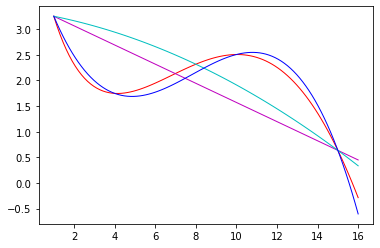

In [6]:
A = np.array([[1, 1, 1, 1], [4**3, 4**2, 4, 1], [1000, 100, 10, 1], [15**3, 15**2, 15, 1]])
B = np.array([f(1), f(4), f(10), f(15)])

solve_3 = solve(A,B)
f_3 = lambda x: solve_3[0]*x**3 + solve_3[1]*x**2 + solve_3[2]*x + solve_3[3]

fig, ax = plt.subplots()
x = np.linspace(1, 16, 100)
ax.plot(x, f(x), color='r', linewidth=1)
ax.plot(x, f_1(x), color='m', linewidth=1)
ax.plot(x, f_2(x), color='c', linewidth=1)
ax.plot(x, f_3(x), color='b', linewidth=1)
plt.show()

In [129]:
with open('2.txt', 'w') as file:
    print(*reversed(solve_3), file=file, end='')
print(*reversed(solve_3))

4.3626415351180725 -1.2955258656948443 0.19333684702151174 -0.008235651173320558
